In [1]:
import feets.preprocess
from scipy import stats
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import feets
from ipykernel import kernelapp as app
import os



script_dir = os.path.dirname('Results/')
results_dir = os.path.join(script_dir, 'Images/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

In [89]:
url = "https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_lightcurves.csv"
url1 = 'https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_labels.csv'
url2 = 'https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_info.txt'
transient_lc = pd.read_csv(url)
transient_labels = pd.read_csv(url1)
transient_info = pd.read_table(url2)

# Isolation forest Machine Learning 5 points cut

In [2]:
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [74]:
# Reading in the feature.csv data
ft_data = pd.read_csv('features.csv',skiprows=1,names= ['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
                                                  'CAR_sigma', 'Con', 'Eta_e', 'Freq1_harmonics_rel_phase_1',
                                                  'LinearTrend', 'MaxSlope', 'Mean', 'Period_fit', 
                                                  'SlottedA_length','SmallKurtosis', 'StructureFunction_index_21'
                                                  ,'ID','Class'])


ft_data.head()

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_sigma,Con,Eta_e,Freq1_harmonics_rel_phase_1,LinearTrend,MaxSlope,Mean,Period_fit,SlottedA_length,SmallKurtosis,StructureFunction_index_21,ID,Class
0,1.121350,0.219645,1.0,0.384615,10.000000,0.000000,3.725561e+08,1.056055,0.000116,170.977771,20.170408,-inf,6.0,0.032874,1.512680,TranID1409030010044114444,SN?
1,1.504750,1.000000,2.0,0.411765,10.000000,0.015152,1.639083e+07,0.133163,-0.000216,310.686183,20.125262,1.000000,6.0,10.438348,1.742156,TranID1209210010044118805,Flare
2,1.532200,1.000000,8.0,0.345946,10.000000,0.032787,2.411989e+06,-0.209898,-0.000333,317.453004,19.331475,0.000000,1.0,3.227174,1.723731,TranID1310250040014131234,SN
3,1.079025,0.878542,2.0,0.384615,7.776815,0.000000,1.842211e+08,1.762472,0.000239,282.088642,20.079277,0.999999,6.0,-0.361120,1.379004,TranID801010040034114166,Var?
4,1.247400,0.999302,2.0,0.414634,10.000000,0.000000,8.020303e+06,1.009082,0.000009,123.993913,20.123456,0.970337,17.0,0.000310,1.731060,TranID1011080040044131101,SN


### Data preprocessing

In [75]:
#Handling missing values
from sklearn.impute import SimpleImputer
import math

math.inf


inf

In [76]:
params = ['Amplitude','AndersonDarling', 'Autocor_length','Beyond1Std','CAR_sigma','Con',
          'Eta_e','Freq1_harmonics_rel_phase_1','LinearTrend','MaxSlope','Mean', 
          'SlottedA_length', 'SmallKurtosis','StructureFunction_index_21']

X = ft_data[params]

# X[X==np.inf]=np.nan



#Handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan,strategy="mean")
imputer.fit(X)
X = imputer.transform(X)
# print(X)

In [86]:
model=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.01),max_features=1.0)
model.fit(X)



ft_data['iforest'] = pd.Series(model.predict(X))

ft_data['iforest_Counts'] = ft_data['iforest'].map({1:0,-1:1})

ft_data['iforest'].value_counts()

 1    4226
-1      43
Name: iforest, dtype: int64

In [87]:
ft_data

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_sigma,Con,Eta_e,Freq1_harmonics_rel_phase_1,LinearTrend,MaxSlope,Mean,Period_fit,SlottedA_length,SmallKurtosis,StructureFunction_index_21,ID,Class,iforest,iforest_Counts
0,1.121350,0.219645,1.0,0.384615,10.000000,0.000000,3.725561e+08,1.056055,0.000116,170.977771,20.170408,-inf,6.0,0.032874,1.512680,TranID1409030010044114444,SN?,1,0
1,1.504750,1.000000,2.0,0.411765,10.000000,0.015152,1.639083e+07,0.133163,-0.000216,310.686183,20.125262,1.000000,6.0,10.438348,1.742156,TranID1209210010044118805,Flare,1,0
2,1.532200,1.000000,8.0,0.345946,10.000000,0.032787,2.411989e+06,-0.209898,-0.000333,317.453004,19.331475,0.000000,1.0,3.227174,1.723731,TranID1310250040014131234,SN,1,0
3,1.079025,0.878542,2.0,0.384615,7.776815,0.000000,1.842211e+08,1.762472,0.000239,282.088642,20.079277,0.999999,6.0,-0.361120,1.379004,TranID801010040034114166,Var?,1,0
4,1.247400,0.999302,2.0,0.414634,10.000000,0.000000,8.020303e+06,1.009082,0.000009,123.993913,20.123456,0.970337,17.0,0.000310,1.731060,TranID1011080040044131101,SN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,0.410500,0.750884,1.0,0.142857,10.000000,0.000000,1.118569e+04,0.106657,0.038746,36.486784,18.521286,0.868202,12.0,2.720123,1.666983,TranID1310131381024102178,SN,1,0
4265,1.551600,0.999976,1.0,0.368421,10.000000,0.000000,6.320444e+04,-2.048107,0.000653,53.395444,19.466837,0.015421,11.0,1.420286,1.836914,TranID1009110011274140658,CV,1,0
4266,0.867350,0.696630,1.0,0.285714,10.000000,0.000000,4.347377e+09,-0.972942,-0.000186,304.892545,20.060957,NaN,510.0,-0.098932,1.881218,TranID1006191261154142735,SN,-1,1
4267,1.328975,0.962269,1.0,0.324324,10.000000,0.000000,7.344432e+05,0.248990,0.000038,685.146406,19.081273,0.000103,2.0,0.068273,1.462707,TranID1409031291124154648,CV,1,0


In [122]:
pred=ft_data.loc[ft_data['iforest'] == -1]

for x in range(len(pred.ID)):
    
    lc = transient_lc[transient_lc['ID']==pred.ID.iloc[x]]
    
#     print(pred.ID.iloc[x],len(lc))

In [123]:
# pred

In [121]:
count = 0

for i in range(len(pred.ID)):
    
    lc = transient_lc[transient_lc['ID']==pred.ID.iloc[i]]
    
    if len(lc)<10:
        
        count += 1
    
#     print('perriod_fit=',round(pred.Period_fit.iloc[i],2),'  #points',len(lc),pred.Class.iloc[i])
        
    else:  
        
        print('perriod_fit=',round(pred.Period_fit.iloc[i],2),'  #points',len(lc),pred.Class.iloc[i])
        
#         print('perriod_fit=',round(pred.Period_fit.iloc[i],2),'  #points',len(lc))


#     lc = transient_lc[transient_lc['ID']=='TranID1609221010114117243']
#     plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=pred.Class.iloc[i])
#     plt.legend(fontsize=12)
#     plt.xlabel('MJD')
#     plt.ylabel('Mag')
#     plt.show()

perriod_fit= 0.0   #points 299 Flare
perriod_fit= 0.0   #points 348 Flare
perriod_fit= 0.0   #points 360 Flare
perriod_fit= 1.0   #points 345 Flare
perriod_fit= 0.0   #points 372 Var
perriod_fit= 1.0   #points 330 Flare
perriod_fit= 0.0   #points 159 Mira
perriod_fit= 0.0   #points 101 HPM
perriod_fit= 1.0   #points 492 CV
perriod_fit= 1.0   #points 259 Flare
perriod_fit= 0.93   #points 197 CV
perriod_fit= 0.0   #points 385 CV
perriod_fit= 1.0   #points 200 Flare
perriod_fit= 1.0   #points 11 SN
perriod_fit= 1.0   #points 191 HPM
perriod_fit= 1.0   #points 170 HPM
perriod_fit= 0.07   #points 343 CV
perriod_fit= 1.0   #points 188 HPM
perriod_fit= 1.0   #points 348 CV
perriod_fit= 0.0   #points 40 YSO
perriod_fit= 0.0   #points 429 CV
perriod_fit= 0.0   #points 265 CV
perriod_fit= 1.0   #points 63 HPM


# Isolation forest Machine Learning 10 points cut

In [274]:
# Reading in the feature.csv data
ft_data = pd.read_csv('features10.csv',skiprows=1,names= ['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
                                                  'CAR_sigma', 'Con', 'Eta_e', 'Freq1_harmonics_rel_phase_1',
                                                  'LinearTrend', 'MaxSlope', 'Mean', 'Period_fit', 
                                                  'SlottedA_length','SmallKurtosis', 'StructureFunction_index_21'
                                                  ,'ID'])


ft_data.head()

params = ['Amplitude','AndersonDarling', 'Autocor_length','Beyond1Std','CAR_sigma','Con',
          'Eta_e','Freq1_harmonics_rel_phase_1','LinearTrend','MaxSlope','Mean', 
          'SlottedA_length', 'SmallKurtosis','StructureFunction_index_21']

X = ft_data[params]

# X[X==np.inf]=np.nan



#Handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan,strategy="mean")
imputer.fit(X)
X = imputer.transform(X)

In [276]:
# # Adding the class column to the feature data
# classs = []
# for i in range(len(ft_data)):
    
#     for j in range(len(class_data.Class)):
        
#         if class_data.ID.iloc[j] == ft_data.ID.iloc[i]:
            
#             classs.append(class_data.Class.iloc[j])
            
# ft_data['Class'] = classs

In [ ]:
# Reading in the data

ft_data = pd.read_csv('features10.csv',skiprows=1,names= ['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
                                                  'CAR_sigma', 'Con', 'Eta_e', 'Freq1_harmonics_rel_phase_1',
                                                  'LinearTrend', 'MaxSlope', 'Mean', 'Period_fit', 
                                                  'SlottedA_length','SmallKurtosis', 'StructureFunction_index_21'
                                                  ,'ID'])


# Adding the class column to the feature data
classs = []
for i in range(len(ft_data)):
    
    for j in range(len(class_data.Class)):
        
        if class_data.ID.iloc[j] == ft_data.ID.iloc[i]:
            
            classs.append(class_data.Class.iloc[j])
            
ft_data['Class'] = classs




# Getting the parameters for the model
params = ['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
                                                  'CAR_sigma', 'Con', 'Eta_e', 'Freq1_harmonics_rel_phase_1',
                                                  'LinearTrend', 'Mean', 
                                                  'SlottedA_length','SmallKurtosis', 'StructureFunction_index_21']


# X data
X = ft_data[params]
#Handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan,strategy="mean")
imputer.fit(X)
X = imputer.transform(X)
# print(X)

AttributeError: 'DataFrame' object has no attribute 'Class'

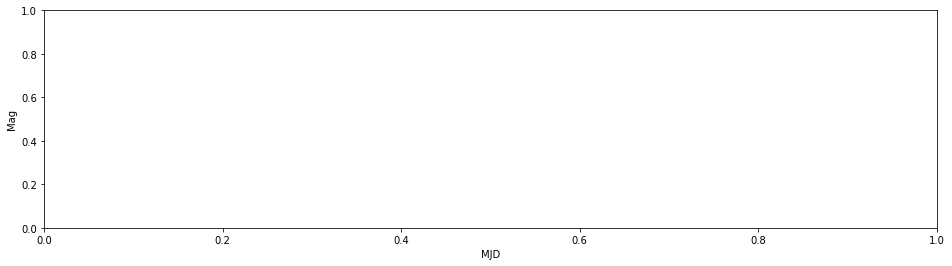

In [279]:
# Defining the model
model=IsolationForest(n_estimators=700, max_samples='auto', contamination=float(0.0003),max_features=1.0)
model.fit(X)


# Predicting the anomalies
ft_data['iforest'] = pd.Series(model.predict(X))
ft_data['iforest_Counts'] = ft_data['iforest'].map({1:0,-1:1})
# Counting the detected anomalies
ft_data['iforest'].value_counts()

# Analysing the predicted anomalies
pred=ft_data.loc[ft_data['iforest'] == -1]
for i in range(len(pred.ID)):
    
    
    plt.figure(figsize=(16,4))
    plt.xlabel('MJD')
    plt.ylabel('Mag')
    lc = transient_lc[transient_lc['ID']==pred.ID.iloc[i]]
    print(len(lc),pred.Class.iloc[i])
    plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=pred.Class.iloc[i])
    plt.legend()
    plt.show()
    

11 SN


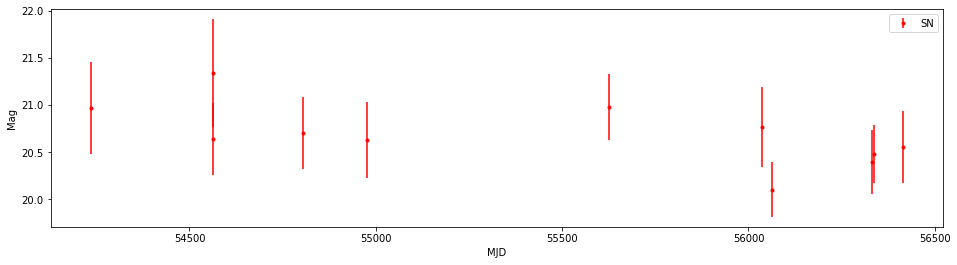

40 YSO


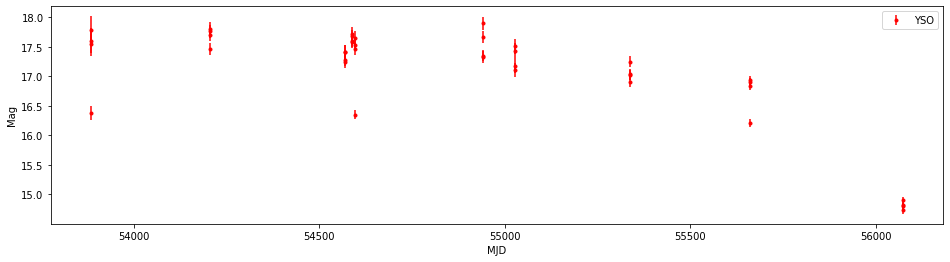

In [265]:
count = 0

pred=ft_data.loc[ft_data['iforest'] == -1]
for i in range(len(pred.ID)):
    
    
    plt.figure(figsize=(16,4))
    plt.xlabel('MJD')
    plt.ylabel('Mag')
    lc = transient_lc[transient_lc['ID']==pred.ID.iloc[i]]
    print(len(lc),pred.Class.iloc[i])
    plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=pred.Class.iloc[i])
    plt.legend()
    plt.show()
    
#     if len(lc)<10:
        
#         count += 1
    
# #     print('perriod_fit=',round(pred.Period_fit.iloc[i],2),'  #points',len(lc),pred.Class.iloc[i])
        
#     else:  
        
#     print('perriod_fit=',round(pred.Period_fit.iloc[i],2),'  #points',len(lc),pred.Class.iloc[i],'ID', pred.ID.iloc[i])
        